<H1>Optimization model with simplification of non-linear and control processes</H1>

Imports and global constants

In [577]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import LibraryTimo_TD
import LibraryTimo_HP
import LibraryTimo_DH
import plotGenerator
import pandas as pd
from scipy.constants import pi
from math import exp, log
import plotly.graph_objects as go
import datetime
from scipy.signal import find_peaks
import os

K = 273                 # [K]

PreCalc = True          
saveRun = True
saveDir = "Optimizations/Combination/2606/AC4a/"

# AC4a		 94kW 	 100kW 
#  AC4b		 147kW 	 160kW 
# SolarPark  300 kW  350 kW
#  AC5a		 535kW 	 630kW 
#  AC5b		 850kW 	 1.000kW 
#  AC5	     1.700kW 2.000kW 


os.makedirs(saveDir, exist_ok=True)


readMe = "Combination optimization to minimize costs with AC4a bounds. Precalc=True, loadShift = True, Px=1000, Pgrid -100-94"

try:
    with open(f"{saveDir}readMe.txt", 'w') as file:
        file.write(readMe)
except IOError as e:
    print(f"Error saving string to file: {e}")

loadShift = True
PcurtailHP = 1000

PgridLB = -100          # kW
PgridUB = 94

Network and simulation definitions

In [578]:
# Simulation timespan selecting the days to be simulated/optimized

startDay = 0
endDay = 365

In [579]:
dataOffset = startDay * 24 * 4          # Data offset for non Gurobi variables

ts = (endDay-startDay) * 24 * 4         # Simulation timesteps
dt = 15 * 60                            # Amount of seconds in timesteps
hour = dt/(60*60)                       # Timestep in hours



nodes = ["N0", "N1", "N2", "N3", "N4", "N5", "N6", "N7", "N8", "N9", "N10", "N11", "N12", "N13", "N14", "N15", "N16"] # Network nodes

connections = [("N0", "N1"), ("N1", "N2"), ("N2", "N3"), ("N3", "N4"), 
            ("N4", "N5"), ("N5", "N6"), ("N6", "N7"), ("N7", "N8"), 
            ("N8", "N9"), ("N9", "N10"), ("N10", "N11"), ("N11", "N12"), 
            ("N12", "N13"), ("N13", "N14"), ("N14", "N15"),("N15","N16"),("N16","N0")]  # Network connections
    



pipeLengths = [100,30,30,45,45,50,50,30,30,50,60,50,40,30,50,30,70]     # Heating network pipe lenghts / assume xtra heat is combined on PVT node
connection_lengths = { (a, b): l for (a, b), l in zip(connections, pipeLengths) }       # Coupling between connections and the lengths of the connections


buildings = nodes[2:17]     # The nodes with buildings attached

<H3>Constants</H3>

Initial surface temperature

In [580]:
T_s_0 = 11 + K

DHN

In [581]:
mf_dot = 50                 # Mass flow in and out aquifier (kg/s)
c_f = 4200                  # Specific heat of fluid (water) (J/(kg*K))
density = 1000                          #  fluid density [kg/m^3]

T_0_DHN = 17.5 + K            # Initial temperature of the district heating network (C)

Heatpumps

In [582]:
m_dot_HP = 10               # mass flow rate (kg/s)
c_f_HP = 4200               # Fluid specific heat (J/(kg*K))

Mass capacity buildings

In [583]:
mc_T = []

# fill mc_T for the three building types
for i in range(3):
    mc_T.insert(i,LibraryTimo_TD.massCapacity(i+1))             # Thermal mass in [J/K]

Pipe resistance

In [584]:
# Pipe parameters
k_soil = 1.19                         # Soil thermal conductivity [W/m*K]
diameters = [0.13, 0.15, 0.40]        # [inner, outer-pipe inner-insulation, outer]  [m]

k_f = 0.6071                           # Thermal conductivity fluid     [W/m*K]
k_tubes = [398, 0.038]                 # [Thermal conductivity tube, Thermal conductivity insulation]  [W/m*K]
H = 1                                  # Depth of pipe [m] center to surface

density = 1000                          #  fluid density [kg/m^3]
viscR = 1e-6                        # kinematic viscosity [m^2/s]
viscP = 0.8927e-6                       # also kinematic viscosity [m^2/s] = dynamic viscosity / density

Reynolds =  4*mf_dot/(density*pi*diameters[0]*viscR)        # Reynolds number []

Prantl =  viscP/(k_f/(density*c_f))                         # Prantl number []


# Fluid conductivee heat transfer
if Reynolds == 0:
    fcht =  2*k_f/diameters[0]
elif Reynolds < 2300:
    fcht = 4.36*k_f/diameters[0]
else:
    fcht = 0.023*k_f*(Reynolds**0.8)*(Prantl**0.4)/diameters[0]     # FCHT [W/K]
R_convective = 1/(pi*diameters[0]*fcht)                     

R_conductive1 = log(diameters[1]/diameters[0])/(2*pi*k_tubes[0])
R_conductive2 = log(diameters[2]/diameters[1])/(2*pi*k_tubes[1])
R_conductive3 = log(2*H/diameters[2])/(2*pi*k_soil)
R_total = R_convective + R_conductive1 + R_conductive2 + R_conductive3  # [K/m*W]

ATES

In [585]:
r = 110                 # Radius (m)
H_ates = 10             # Ates height (m)
c_f = 4200              # Specific heat of fluid (water) (J/(kg*K))
c_r = 830               # Specifi heat of sand (rock)    (J/(kg*K))
n = 0.2                 # Portion of water 0.2 (0.8 sand/rock)
rho_f = 1050            # Density of fluid (kg/m^3)
rho_r = 1602            # Density of sand/rock (kg/m^3)
k_soil = 1.19           # Soil thermal conductivity (W/(m*K))
T_soil = 11 + K         # Soil temperature (K) (assumed constant at aquifer depth)

A_top = A_bottom = np.pi*r**2      # Top and bottom area of aquifier (m^2)
A_side = 2*r*np.pi*H_ates          # Side area of aquifier (m^2)
h_ATE = k_soil/H_ates              # The conductive heat transfer coefficient (W/(m^2*K))

V_ates =  np.pi*H_ates*r**2            # Total ates volume (m^3)
m_w = n*rho_f*V_ates                   # mass of water (fluid) in ates (kg)
m_r = (1-n)*rho_r*V_ates               # mass of rock/sand in ates (kg)

# ATES Pump

eff_ATEP = 0.8                  # []
g = 9.81                        # [m/s^2]
depth = 150                     # [m]
L = 150                         # [m]
diameter= 0.13                  # [m]

Vdot = mf_dot/rho_f             # volumetric flow rate [m^3/s]

A = np.pi * (diameter / 2) ** 2     # Flow area [m]
V = Vdot / A                        # Flow velocity [m/s]

if Reynolds > 4000:
    # Turbulent flow: Calculate friction factor using Blasius correlation
    f = 0.3164 * Reynolds ** -0.25                      # []
else:
    # Laminar flow: Calculate darcy friction factor
    f = 64 / Reynolds                                   # []



P_l = f * (1/diameter) * (rho_f*V ** 2 /2)         # Pressure loss per unit length [Pa/m]

P_ATEP = ((Vdot*(rho_f*g*depth + L*P_l))/eff_ATEP)/1000    # Ates pump power [kW]

CSV imports

In [586]:
T_amb_imp = np.loadtxt('data/Main/Tamb_KNMI_21tm23_Q.csv', delimiter=';')    # T ambient in De Bilt from 2021 until 2023, quarterly values (C)
G = np.loadtxt('data/Main/G_DeBilt_21_23_Q.csv', delimiter=';')              # Irradiance quarterly values (W/m^2)
Vw = np.loadtxt('data/Main/Vwind_DeBilt_21_23_Q.csv', delimiter=';')         # Wind speeds quarterly values (m/s)
Qdot_PVT_Trends = np.loadtxt("data/Main/QdotTrends_10to25.csv", delimiter=";")      # The trends in precalculated Qdot values with the following structure [a, b, r2, PWL binary, X intersect] [W]
P_demand = np.loadtxt('data/Main/deWerf_electricalDemand.csv', delimiter=";")        # The normal building electricity demand per timestep without heat. So building and process. [kW]

T_amb = np.add(T_amb_imp, K)                                            # Ambient termperature (K)

# Calculate surface temperatures for all timesteps

T_s_0 = 11 + K
T_s = [T_s_0]

for step in range(len(T_amb)-1):
    T_s_new = LibraryTimo_DH.surfaceTemperature_C(T_amb[step]-K,G[step],Vw[step],T_s[step]-K) + K
    T_s.append(T_s_new)

Buildings

In [587]:

houseTypes = {"N2": 1, "N3": 1, "N4": 1, "N5": 2, "N6": 1, "N7": 1, "N8": 1, "N9": 1, "N10": 3, "N11": 1, "N12": 1, "N13": 2, "N14": 1, "N15": 2, "N16": 2}             #  Types of buildings in the model
houseN = len(houseTypes)

T_set_0 = 20 + K                 # Building temperature setpoint  [K]

if loadShift:
    T_set_day = [T_set_0 - 3]*int((5-0)*4) + [T_set_0 - 3, T_set_0 - 2.625, T_set_0 - 2.25, T_set_0 - 1.875, T_set_0 - 1.5, T_set_0 - 1.125, T_set_0 - 0.75, T_set_0 - 0.375] + [T_set_0]*int((22-7)*4)+ [T_set_0 - 3]*int((24-22)*4)
    T_set = np.array(T_set_day*int(endDay-startDay))
    T_sup_setpoints = [53+K,55+K,57+K,59+K,61+K,63+K,65+K,67+K,69+K,71+K,73+K]  # Setpoints temperature for HP supply fluid [K]
    
else:
    T_set_day = [T_set_0]*int((6-0)*4) + [T_set_0]*int((22-6)*4)+ [T_set_0]*int((24-22)*4)
    T_set = np.array(T_set_day*int(endDay-startDay))
    T_sup_setpoints = [53+K,53+K,53+K,53+K,53+K,53+K,53+K,53+K,53+K,53+K,53+K]  # Setpoints temperature for HP supply fluid [K]
    



Gbins = [0,100,200,300,400,500,600,700,800,900,1000]




if PreCalc:
    if loadShift:
        Qdot_D = pd.read_csv("Data/PreCalc/Qdot_D_1y_LS.csv", sep=";", index_col=0)
        Qdot_B = pd.read_csv("Data/PreCalc/Qdot_B_1y_LS.csv", sep=";", index_col=0)
        T_ret = pd.read_csv("Data/PreCalc/T_ret_1y_LS.csv", sep=";", index_col=0)
        T_sup = pd.read_csv("Data/PreCalc/T_sup_1y_LS.csv", sep=";", index_col=0)
        Qdot_HP = pd.read_csv("Data/PreCalc/Qdot_HP_1y_LS.csv", sep=";", index_col=0)
        T_inside = pd.read_csv("Data/PreCalc/T_inside_1y_LS.csv", sep=";", index_col=0)
    else:
        Qdot_D = pd.read_csv("Data/PreCalc/Qdot_D_1y.csv", sep=";", index_col=0)
        Qdot_B = pd.read_csv("Data/PreCalc/Qdot_B_1y.csv", sep=";", index_col=0)
        T_ret = pd.read_csv("Data/PreCalc/T_ret_1y.csv", sep=";", index_col=0)
        T_sup = pd.read_csv("Data/PreCalc/T_sup_1y.csv", sep=";", index_col=0)
        Qdot_HP = pd.read_csv("Data/PreCalc/Qdot_HP_1y.csv", sep=";", index_col=0)
        T_inside = pd.read_csv("Data/PreCalc/T_inside_1y.csv", sep=";", index_col=0)
else:
    Qdot_D = pd.DataFrame(index = range(ts), columns = buildings)
    Qdot_B = pd.DataFrame(index = range(ts), columns = buildings)
    T_sup = pd.DataFrame(index = range(ts+1), columns = buildings)
    T_ret = pd.DataFrame(index = range(ts), columns = buildings)
    T_inside = pd.DataFrame(index = range(ts+1), columns = buildings)
    Qdot_HP = pd.DataFrame(index = range(ts), columns = buildings)

    Gmap = np.digitize(G,Gbins)-1

    for building in buildings:
        T_sup.loc[0,building] = T_sup_setpoints[0]
        T_inside.loc[0,building] = T_set_0
        for t in range(ts):
            
            T_sup_set = T_sup_setpoints[Gmap[t]]

            T_ret_min = T_sup_set - 3                   # Normally 50 degrees

            Qdot_D.loc[t,building] = LibraryTimo_TD.House_Thermal_losses(houseTypes[building], T_inside.loc[t,building], T_amb[t+dataOffset])

            if Qdot_D.loc[t,building] <= 0 and T_inside.loc[t,building]<=T_set[t+dataOffset]:
                # Qdot_B.loc[t,building] = -Qdot_D.loc[t,building]
                Qdot_B.loc[t,building] = ((T_set[t+dataOffset] - T_inside.loc[t,building])*(mc_T[houseTypes[building]-1]))/dt - Qdot_D.loc[t,building]
                Qdot_B.loc[t,building] = min(Qdot_B.loc[t,building], 75000)
            else:
                Qdot_B.loc[t,building] = 0

            T_ret.loc[t,building] = T_sup.loc[t,building] - ((Qdot_B.loc[t,building])/(m_dot_HP*c_f_HP))

            if T_ret.loc[t,building] <= T_ret_min:
                T_sup.loc[t+1,building] = T_sup_set
                Qdot_HP.loc[t,building] = LibraryTimo_HP.HP_Power(T_ret.loc[t,building], m_dot_HP, c_f_HP, T_sup.loc[t+1,building])
            else:
                T_sup.loc[t+1,building] = T_ret.loc[t,building]
                Qdot_HP.loc[t,building] = 0

            T_inside.loc[t+1, building] = (T_inside.loc[t, building] + dt * (Qdot_D.loc[t,building] + Qdot_B.loc[t,building])/(mc_T[houseTypes[building]-1]))

    if loadShift:
        Qdot_D.to_csv("Data/PreCalc/Qdot_D_1y_LS.csv", sep=";")
        Qdot_B.to_csv("Data/PreCalc/Qdot_B_1y_LS.csv", sep=";")
        T_ret.to_csv("Data/PreCalc/T_ret_1y_LS.csv", sep=";")
        T_sup.to_csv("Data/PreCalc/T_sup_1y_LS.csv", sep=";")
        Qdot_HP.to_csv("Data/PreCalc/Qdot_HP_1y_LS.csv", sep=";")
        T_inside.to_csv("Data/PreCalc/T_inside_1y_LS.csv", sep=";")
    else:
        Qdot_D.to_csv("Data/PreCalc/Qdot_D_1y.csv", sep=";")
        Qdot_B.to_csv("Data/PreCalc/Qdot_B_1y.csv", sep=";")
        T_ret.to_csv("Data/PreCalc/T_ret_1y.csv", sep=";")
        T_sup.to_csv("Data/PreCalc/T_sup_1y.csv", sep=";")
        Qdot_HP.to_csv("Data/PreCalc/Qdot_HP_1y.csv", sep=";")
        T_inside.to_csv("Data/PreCalc/T_inside_1y.csv", sep=";")

<H3>Simulation / Optimization</H3>

Environment/model initialization

In [588]:
remote = False

try:
    alive # type: ignore
except NameError:
    alive = False

if alive:
    m.dispose()     # type: ignore
    env.dispose()   # type: ignore

if remote:

    env = gp.Env(empty=True)
    env.setParam("ComputeServer","149.143.55.98:1234")
    


    env.start()

    alive = True

    m = gp.Model("Closed Distribution System Optimization", env=env)

else:

    m = gp.Model("Closed Distribution System Optimization")

In [589]:
# m.dispose()     # type: ignore
# env.dispose()   # type: ignore

Variables

In [590]:
# Temperature variables
Tin = m.addVars(ts, nodes, vtype=GRB.CONTINUOUS, lb=273, ub=323, name="Tin") # Temperature of the nodes at time t     [K]
Tout = m.addVars(ts, nodes, vtype=GRB.CONTINUOUS, lb=273, ub=323, name="Tout") # Temperature of the nodes at time t   [K]

# Vertice and node variables
Qdot_ij = m.addVars(ts, connections, vtype=GRB.CONTINUOUS, lb=0, name="Qdot_ij") # Heat flow between nodes i and j at time t       [kW]
Qdot_n = m.addVars(ts, nodes, vtype=GRB.CONTINUOUS, lb=-10000, ub=10000, name="Qdot_n") # Net heat flow per node                   [kW]

# Ates variables
Qdot_top = m.addVars(ts, vtype=GRB.CONTINUOUS, lb=-1000, ub=1000, name="Qdot_top") # Heat flow from the top of the acquifier at time t              [kW]
Qdot_bottom = m.addVars(ts, vtype=GRB.CONTINUOUS, lb=-1000, ub=1000, name="Qdot_bottom") # Heat flow from the bottom of the acquifier at time t     [kW]
Qdot_side = m.addVars(ts, vtype=GRB.CONTINUOUS, lb=-1000, ub=1000, name="Qdot_side") # Heat flow from the side of the acquifier at time t           [kW]
Qdot_soil = m.addVars(ts, vtype=GRB.CONTINUOUS, lb=-1000, ub=1000, name="Qdot_soil") # Heat flow from the soil to the acquifier at time t           [kW]

# Variables PVT
Qdot_pvt = m.addVars(ts, vtype=GRB.CONTINUOUS, ub=3000, name="Qdot_pvt") # Heat flow from a single PVT panel at time t      [W]
P_pvt = m.addVars(ts, vtype=GRB.CONTINUOUS, ub=1000, name="P_pvt")  # PVT electrical power [kW]

# Variables PV
kWp_pv = m.addVar(vtype=GRB.CONTINUOUS, name="kWp_pv")                      # Installed solar power [kWp]
P_pv = m.addVars(ts, vtype=GRB.CONTINUOUS, ub=1700, name="P_pv")            # PV panels electrical output [kW]

# Variables HP
P_hp = m.addVars(ts,buildings, vtype=GRB.CONTINUOUS, lb=-1000, ub=1000, name="P_hp")     # HP power per building [kW]
COP_hp = m.addVars(ts,buildings, vtype=GRB.CONTINUOUS, lb=1, ub=5, name="COP_hp")        # HP COP per building []
Qdot_network = m.addVars(ts,buildings, vtype=GRB.CONTINUOUS, lb=-1000, ub=1000, name="Qdot_network")    # Heat extracted from network by HP [kW]

P_hp_x = m.addVars(ts, vtype=GRB.CONTINUOUS, ub=PcurtailHP, name="P_hp_x")

# Pipe variables
Tpipe_in = m.addVars(ts,connections, vtype=GRB.CONTINUOUS, lb=273, ub=323, name="Tpipe_in")     # Temperatures incoming in a pipe
Tpipe_out = m.addVars(ts,connections, vtype=GRB.CONTINUOUS, lb=273, ub=323, name="Tpipe_out")   # Temperatures coming out of a pipe

# Grid power
P_grid = m.addVars(ts, vtype=GRB.CONTINUOUS, lb=PgridLB, ub=PgridUB, name="P_grid")        # Grid electrical power [kW]
P_grid_peak = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="P_grid_peak")

# Battery variables
E_bess = m.addVars(ts, vtype=GRB.CONTINUOUS, lb=0, ub=1000, name="E_bess")         # Battery energy level (SOC) [MWh]
P_bess = m.addVars(ts, vtype=GRB.CONTINUOUS, lb=-1000, ub=1000, name="P_bess")      # Battery power [MW]
E_bess_max = m.addVar(vtype=GRB.CONTINUOUS, ub=1000, name="E_bess_max")            # Battery max energy level (capacity) [MWh]
P_bess_max = m.addVar(vtype=GRB.CONTINUOUS, ub=1000, name="P_bess_max")            # Battery max power output [MW]

Constraints

In [591]:
nPVT = 800


# Calculate the exp factors for the pipe losses once
exp_factors = {(i, j): exp(-connection_lengths[i, j] / (mf_dot * c_f * R_total)) for (i, j) in connections}

# Calculate this factor for ates temperature update once
dt_factor = dt / (m_w * c_f + m_r * c_r)

# --- Power Balance & Grid Peak Constraints ---
m.addConstrs(
    (P_grid[t] + P_bess[t]*1000 + P_pvt[t] + P_pv[t] - P_demand[t+dataOffset]- P_ATEP - P_hp_x[t] - gp.quicksum(P_hp[t, b] for b in buildings) == 0
    for t in range(ts)), name="PowerBalance"
)

m.addConstrs((P_grid[t] <= P_grid_peak for t in range(ts)), name="Pgridmax")
m.addConstrs((-P_grid[t] <= P_grid_peak for t in range(ts)), name="Pgridmin")

# --- ATES Heat Losses ---
m.addConstrs((Qdot_top[t]    == (h_ATE * A_top   * (T_soil - Tout[t, "N0"])) / 1000 for t in range(ts)), name="TopLoss")
m.addConstrs((Qdot_bottom[t] == (h_ATE * A_bottom * (T_soil - Tout[t, "N0"])) / 1000 for t in range(ts)), name="BotLoss")
m.addConstrs((Qdot_side[t]   == (h_ATE * A_side  * (T_soil - Tout[t, "N0"])) / 1000 for t in range(ts)), name="SideLoss")
m.addConstrs((Qdot_soil[t]   == Qdot_top[t] + Qdot_bottom[t] + Qdot_side[t] for t in range(ts)), name="SoilLoss")


# --- PVT and PV Constraints ---
for t in range(ts):
    if Qdot_PVT_Trends[t+dataOffset][3]:
        x_val = [10+K, Qdot_PVT_Trends[t+dataOffset][4], 25+K]
        y_val = [Qdot_PVT_Trends[t+dataOffset][0]*(10+K) + Qdot_PVT_Trends[t+dataOffset][1], 0, 0]
        m.addGenConstrPWL(Tin[t, "N1"], Qdot_pvt[t], x_val, y_val, name=f"PVTtrendline_{t}")
        
    else:
        m.addConstr((Qdot_pvt[t] == Qdot_PVT_Trends[t+dataOffset][0]*Tin[t,"N1"] + Qdot_PVT_Trends[t+dataOffset][1]), name="PVTtrendline@t")

m.addConstrs((P_pvt[t] == nPVT * (G[t+dataOffset] * 1.77 * 0.18) / 1000 for t in range(ts)), name="P_PVT") # 0.18 is a safe average
m.addConstrs((P_pv[t] == kWp_pv * G[t+dataOffset] / 1000 for t in range(ts)), name="P_PV")

m.addConstrs((
    COP_hp[t, b] == -0.082 * (T_ret.loc[t, b] - Tin[t, b]) + 6.2917
    for t in range(ts) for b in buildings
), name="COP_HP")

# 1/COP is linearized
m.addConstrs((
    Qdot_network[t, b] == (Qdot_HP.loc[t, b] / 1000) * (1 - (-0.007 * Tin[t, b] + 2.3222))
    for t in range(ts) for b in buildings
), name="QdotNetwork")

m.addConstrs((Qdot_n[t, b] == -Qdot_network[t, b] for t in range(ts) for b in buildings), name="QdotNBuilding")

# 1/COP is linearized
m.addConstrs((
    P_hp[t, b] == (Qdot_HP.loc[t, b] / 1000) * (-0.007 * Tin[t, b] + 2.3222)
    for t in range(ts) for b in buildings
), name="P_HP")

# --- Node Power Flow ---
m.addConstrs((Qdot_n[t, "N1"] == nPVT * Qdot_pvt[t]/1000 + P_hp_x[t]*3.8 for t in range(ts)), name="Qdot_N1")

# --- Pipe Heat Flow and Temperatures ---
m.addConstrs((
    Qdot_ij[t, i, j] == (Tout[t, i] * mf_dot * c_f) / 1000
    for t in range(ts) for (i, j) in connections
), name="Qdot_ij")

m.addConstrs((
    Tpipe_out[t, i, j] == T_s[t + dataOffset] - (T_s[t + dataOffset] - Tpipe_in[t, i, j]) * exp_factors[i, j]
    for t in range(ts) for (i, j) in connections
), name="TpipeOut")


# --- Node Power Input/Output ---
m.addConstrs((
    Qdot_n[t, n] == (mf_dot * c_f * (Tout[t, n] - Tin[t, n])) / 1000
    for t in range(ts) for n in nodes
), name="Qdot_Node")

m.addConstrs((
    Tin[t, n] == Tpipe_out[t, i, j]
    for t in range(ts) for n in nodes for (i, j) in connections if j == n
), name="TinFromPipe")

m.addConstrs((
    Tout[t, n] == Tpipe_in[t, i, j]
    for t in range(ts) for n in nodes for (i, j) in connections if i == n
), name="ToutFromPipe")

# --- ATES Temperature Update ---
m.addConstrs((
    Tout[t+1, "N0"] * 1000 == (Tout[t, "N0"] + ((mf_dot * c_f * (Tin[t, "N0"] - Tout[t, "N0"])) + Qdot_soil[t] * 1000) * dt_factor) * 1000
    for t in range(ts - 1)
), name="ATES_TempUpdate")

# --- Battery Update ---
m.addConstrs((E_bess[t+1] == E_bess[t] - P_bess[t] * hour for t in range(ts - 1)), name="BatteryUpdate")
m.addConstrs((E_bess[t] <= E_bess_max for t in range(ts - 1)), name="EbessMAX")
m.addConstrs((P_bess[t] <= P_bess_max for t in range(ts - 1)), name="PbessMAX")

m.addConstr(P_bess_max == E_bess_max)
m.addConstr(P_bess[ts-1] == P_bess[ts-2])


# --- Initial & Time-Invariant Constraints ---
m.addConstr(kWp_pv / 1000 <= 1000, name="nPVMax")
m.addConstr(E_bess[0] == E_bess_max/2, name="InitialBattery")
m.addConstr(E_bess[ts-1] == E_bess_max/2, name="InitialBatteryEnd")
m.addConstr(Tout[0, "N0"] == T_0_DHN, name="InitialTout")


print("Constraint end")

Constraint end


Objective function

In [592]:
# m.setObjective(Tout[ts-1,\"N0\"], GRB.MAXIMIZE)
# m.setObjective(nPVT, GRB.MINIMIZE)
# m.setObjective(P_grid_peak, GRB.MINIMIZE)
 
Cpv = 1000      # / kWp
Cbess = 600     #/kWh
Copexbess = 1/(1+0.045)

m.setObjective(kWp_pv * Cpv + E_bess_max*1000 * Cbess + (E_bess_max*1000 * Copexbess * Cbess), GRB.MINIMIZE)

Optimization

In [593]:
# Debug parameters
m.setParam("MIPFocus", 1)

# Run the optimization
m.optimize()

Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPFocus  1

Optimize a model with 5594421 rows, 5536324 columns and 11568219 nonzeros
Model fingerprint: 0x267e7ed6
Model has 11981 simple general constraints
  11981 PWL
Variable types: 5536324 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+03]
  Objective range  [1e+03, 1e+06]
  Bounds range     [1e+00, 1e+04]
  RHS range        [9e-03, 2e+04]
  PWLCon x range   [3e+02, 3e+02]
  PWLCon y range   [0e+00, 0e+00]
Presolve removed 5318289 rows and 5250458 columns (presolve time = 5s)...
Presolve removed 5311518 rows and 5246961 columns
Presolve time: 8.97s
Presolved: 282903 rows, 289363 columns, 786795 nonzeros
Presolved model has 11973 SOS constrain

In [594]:
# m.computeIIS()
# m.write("infeasible_constraints.ilp")
# m.write("model.lp")

<H1>Optimization results</H1>

Number of PV and PVT panels

In [595]:
TotalCost = m.ObjVal
kWpPV = kWp_pv.X
Emax = E_bess_max.X
Pgridmax = P_grid_peak.X
print(f"Total cost = {TotalCost}")
print(f"kwp PV = {kWpPV}")
print(f"Emax = {Emax}")
print(f"Pgrid max = {Pgridmax}")

if saveRun:
    # Define the filename
    output_filename = f"{saveDir}optimization_results.csv"

    try:
        with open(output_filename, 'w') as file:
            # Write a header row (optional but recommended)
            file.write("Total Cost,kWp PV,Emax,Pgridmax\n")
            # Write the values as a single row
            file.write(f"{TotalCost},{kWpPV},{Emax},{Pgridmax}\n")
    except IOError as e:
        print(f"Error saving results to file: {e}")


Total cost = 533929399.4180381
kwp PV = 1743.5897435897439
Emax = 453.2470832190696
Pgrid max = 100.0


ATES

In [596]:
# ATES Temperature

Tates_p = [Tout[t, "N0"].X-K for t in range(ts)]


data = Tates_p
title = "ATES temperature"
name = "T_ates"
yaxis = "Temperature (°C)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)

In [597]:
# Qdot soil losses

Qsoil = [Qdot_soil[t].X for t in range(ts)]

data = Qsoil
title = "ATES power exchange to soil"
name = "Qsoil"
yaxis = "P (kW)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)

Ambient temperature

In [598]:
# Ambient temperature

data = T_amb[dataOffset:ts+dataOffset]-K
title = "Ambient temperature"
name = "T_amb"
yaxis = "Temperature (°C)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)

Irradiance

In [599]:
# Global irradiance

data = G[dataOffset:ts+dataOffset]
title = "Global irradiance"
name = "G"
yaxis = "G (W/m\u00B2)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)

Heat pumps

In [600]:
# QdotHP

for building in buildings:

    data = Qdot_HP.loc[dataOffset:ts+dataOffset,building]/1000
    title = f"Heatpump thermal power building {building}"
    name = "Qdot_HP"
    yaxis = "P (kW)"

    path = f"{saveDir}{name}/{building}/"

    os.makedirs(path, exist_ok=True)

    fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)
    
    # fig.show()

    if saveRun:

        np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
        plotGenerator.save(name,data,fig,path)

In [601]:
# Power HP

for building in buildings:

    data = [P_hp[t, building].X for t in range(ts)]
    title = f"Heatpump electrical power building {building}"
    name = "P_hp"
    yaxis = "P (kW)"

    path = f"{saveDir}{name}/{building}/"

    os.makedirs(path, exist_ok=True)

    fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)
    
    # fig.show()

    if saveRun:

        np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
        plotGenerator.save(name,data,fig,path)


# Phptotals = [[] for building in buildings]
# i = 0

# for building in buildings:

#     PHP = [P_hp[t, building].X for t in range(ts)]

#     plt.figure(3)
#     plt.plot(PHP)
#     plt.title(f"Electrical power Heat Pump building {building}")
#     plt.xlabel("Timestep (Quarter)")
#     plt.ylabel("P (kW)")
#     plt.show()
#     Phptotals[i].extend(PHP) 
#     i += 1


# if saveRun:

#     np.savetxt(f"{saveDir}Php.csv",np.array(Phptotals).T,delimiter=";")

In [602]:
# COP HP

for building in buildings:

    data = [COP_hp[t, building].X for t in range(ts)]
    title = f"Heatpump COP building {building}"
    name = "COP_hp"
    yaxis = "#"

    path = f"{saveDir}{name}/{building}/"

    os.makedirs(path, exist_ok=True)

    fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)
    
    # fig.show()

    if saveRun:

        np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
        plotGenerator.save(name,data,fig,path)






# for building in buildings:
#     COP = [COP_hp[t, building].X for t in range(ts)]
#     # COPnew = [COP_hp_new[t,building].X for t in range(ts)]

#     peaks = find_peaks(COP)[0]
#     ypeaks = np.array(COP)[peaks.astype(int)]

#     # newPeaks = find_peaks(COPnew)[0]
#     # newYpeaks = np.array(COPnew)[peaks.astype(int)]

 
#     plt.figure(12)
#     plt.plot(ypeaks)
#     plt.title(f"Active COP peaks building {building}")
#     plt.xlabel("Timestep (Quarter)")
#     plt.ylabel("#")
#     plt.show()





Buildings

In [603]:
# Building temperature

for building in buildings:

    data =  [T_inside.loc[t, building]-K for t in range(ts)]
    title = f"Inside temperature building {building}"
    name = "T_ins"
    yaxis = "Temperature (°C)"

    path = f"{saveDir}{name}/{building}/"

    os.makedirs(path, exist_ok=True)

    fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)
        
    # fig.show())

    if saveRun:

        np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
        plotGenerator.save(name,data,fig,path)

# for building in buildings:

#     Tins = [T_inside.loc[t, building]-K for t in range(ts)]

#     plt.figure(1)
#     plt.plot(Tins, label=building)
#     plt.title(f"Inside temperature building {building}")
#     plt.xlabel("Timestep (Quarter)")
#     plt.ylabel("T (C)")
#     plt.legend()
#     plt.show()

In [604]:
# QdotD buildings

for building in buildings:

    data =  Qdot_D.loc[dataOffset:ts+dataOffset,building]/1000
    title = f"Heat losses power building {building}"
    name = "Qdot_D"
    yaxis = "P (kW)"

    path = f"{saveDir}{name}/{building}/"

    os.makedirs(path, exist_ok=True)

    fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)
    
    # fig.show()

    if saveRun:

        np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
        plotGenerator.save(name,data,fig,path)

In [605]:
# QdotB building

for building in buildings:

    data =  Qdot_B.loc[dataOffset:ts+dataOffset,building]/1000
    title = f"Boiler power building {building}"
    name = "Qdot_B"
    yaxis = "P (kW)"

    path = f"{saveDir}{name}/{building}/"

    os.makedirs(path, exist_ok=True)

    fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)
    
    # fig.show()

    if saveRun:

        np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
        plotGenerator.save(name,data,fig,path)

In [606]:
# Tsup boiler

for building in buildings:

    data =  [T_sup.loc[t, building]-K for t in range(ts)]
    title = f"Supply temperature boiler building {building}"
    name = "T_sup"
    yaxis = "Temperature (°C)"

    path = f"{saveDir}{name}/{building}/"

    os.makedirs(path, exist_ok=True)

    fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)
    
    # fig.show()

    if saveRun:

        np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
        plotGenerator.save(name,data,fig,path)


In [607]:
# Tret boiler

for building in buildings:

    data =  [T_ret.loc[t, building]-K for t in range(ts)]
    title = f"Return temperature boiler building {building}"
    name = "T_ret"
    yaxis = "Temperature (°C)"

    path = f"{saveDir}{name}/{building}/"

    os.makedirs(path, exist_ok=True)

    fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)
    
    # fig.show()

    if saveRun:

        np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
        plotGenerator.save(name,data,fig,path)

Nodes

In [608]:
# Qdot N net power

for node in nodes:

    data =  [Qdot_n[t, node].X for t in range(ts)]
    title = f"Net heating power node {node}"
    name = "Qdot_n"
    yaxis = "P (kW)"

    path = f"{saveDir}{name}/{node}/"

    os.makedirs(path, exist_ok=True)

    fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)
    
    # fig.show()

    if saveRun:

        np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
        plotGenerator.save(name,data,fig,path)

# for node in nodes:
#     Qdotn = [Qdot_n[t, node].X for t in range(ts)]
#     plt.figure(12)
#     plt.plot(Qdotn, label=node)
#     plt.title(f"Qdot net power node {node}")
#     plt.xlabel("Timestep (Quarter)")
#     plt.ylabel("P (kW)")
#     plt.legend()
#     plt.show()

In [609]:
# Temperatures in and out

for node in nodes:

    data =  [Tin[t,node].X-K for t in range(ts)]
    title = f"Temperature flows node {node}"
    data2 = [Tout[t,node].X-K for t in range(ts)]
    name = "T_in"
    name2 = "T_out"
    yaxis = "Temperature (°C)"

    path = f"{saveDir}{name}_{name2}/{node}/"

    os.makedirs(path, exist_ok=True)

    fig = plotGenerator.plotGen(title, data, name, data2, name2, ts, yaxis)
    
    # fig.show()

    if saveRun:

        np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
        np.savetxt(f"{path}/{name2}.csv",data2, delimiter=";")
        plotGenerator.save(f"{name}_{name2}",data,fig,path)



Connections and pipes

In [610]:
# Connection power flow

for i,j, in connections:

    data =  [Qdot_ij[t,i,j].X for t in range(ts)]
    title = f"Connection power flow between node {i} and node {j}"
    name = "Qdot_ij"
    yaxis = "P (kW)"

    path = f"{saveDir}{name}/{i}_{j}/"

    os.makedirs(path, exist_ok=True)

    fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)
    
    # fig.show()

    if saveRun:

        np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
        plotGenerator.save(name,data,fig,path)


In [611]:
# delta T pipes

for i,j, in connections:

    Tpin = [Tpipe_in[t,i,j].X for t in range(ts)]
    Tpout = [Tpipe_out[t,i,j].X for t in range(ts)]

    data =  [Tpipe_out[t,i,j].X-Tpipe_in[t,i,j].X for t in range(ts)]
    title = f"Delta temperature pipe connection {i} to {j}"
    name = "dT_pipe"
    yaxis = "P (kW)"

    path = f"{saveDir}{name}/{i}_{j}/"

    os.makedirs(path, exist_ok=True)

    fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)
    
    # fig.show()

    if saveRun:

        np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
        plotGenerator.save(name,data,fig,path)

Temperature through network at timestep

In [612]:
# atTime = 20
# TnetworkArray = []
# for i in range(len(nodes)):
#     current_node = nodes[i]
#     next_node = nodes[(i + 1) % len(nodes)]  # The % operator makes it loop back to 0
#     # print(f"Current: {current_node}, Next: {next_node}")

    
#     TnetworkArray.extend([Tout[atTime,current_node].X, Tpipe_in[atTime,current_node,next_node].X, Tpipe_out[atTime,current_node,next_node].X, Tin[atTime,next_node].X])
# print(TnetworkArray)   

# plt.figure(i)
# plt.plot(np.subtract(TnetworkArray,K), label=f"ts = {atTime}")
# plt.title("Temperature through network")
# plt.xlabel("Timestep (Quarter)")
# plt.ylabel("T (C)")
# plt.legend()
# plt.show()

Electrical power components

In [613]:
# Sum of HP power

Phpsum = [sum(P_hp[t, building].X for building in buildings) for t in range(ts)]

data = Phpsum
title = "Total electrical power heat pumps"
name = "P_hp_sum"
yaxis = "P (kW)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)



# plt.figure(12)
# plt.plot(Phpsum)
# plt.title("Sum of Heat Pump powers")
# plt.xlabel("Timestep (Quarter)")
# plt.ylabel("P (kW)")
# plt.show()

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]



month = 2920

jan = Phpsum[month*0:month*1]
feb = Phpsum[month*1:month*2]
mar = Phpsum[month*2:month*3]
apr = Phpsum[month*3:month*4]
may = Phpsum[month*4:month*5]
jun = Phpsum[month*5:month*6]
jul = Phpsum[month*6:month*7]
aug = Phpsum[month*7:month*8]
sep = Phpsum[month*8:month*9]
okt = Phpsum[month*9:month*10]
nov = Phpsum[month*10:month*11]
dec = Phpsum[month*11:month*12]

data = {
    "Jan": jan,
    "Feb": feb,
    "Mar": mar,
    "Apr": apr,
    "May": may,
    "Jun": jun,
    "Jul": jul,
    "Aug": aug,
    "Sep": sep,
    "Oct": okt,
    "Nov": nov,
    "Dec": dec,
}

# Create the DataFrame
Phpsum_frame = pd.DataFrame(data)


sumPhpsum_Frame = pd.DataFrame(Phpsum_frame.sum()).transpose()
monthly_sums = Phpsum_frame.sum()

print(monthly_sums["Jan"])

# for month in Phpsum_frame:
#     name = ""

jansum = sum(jan)
jansum = sum(jan)
print(jansum)

print(len(Phpsum)/12)
print(len(jan))
print(len(feb))


188026.37485592393
188026.37485592396
2920.0
2920
2920


188026.37485592393


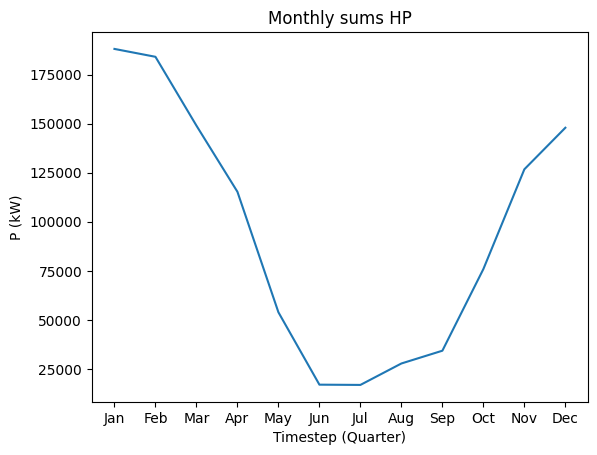

In [614]:
print(sumPhpsum_Frame.loc[0,"Jan"])

plt.figure(12)
plt.plot(monthly_sums)
plt.title("Monthly sums HP")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("P (kW)")
plt.show()

data = monthly_sums
title = "Monthly sums electrical power heat pumps"
name = "P_hp_sum_monthly"
yaxis = "P (kW)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)

In [615]:
# # ATES pump power

# Ppump = [P_ATEP/1000 for i in range(ts)]

# plt.figure(12)
# plt.plot(Ppump)
# plt.title("Ates pump power")
# plt.xlabel("Timestep (Quarter)")
# plt.ylabel("P (kW)")
# plt.show()

data = [P_ATEP for i in range(ts)]
title = "ATES pump electrical power"
name = "P_ATEP"
yaxis = "P (kW)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)

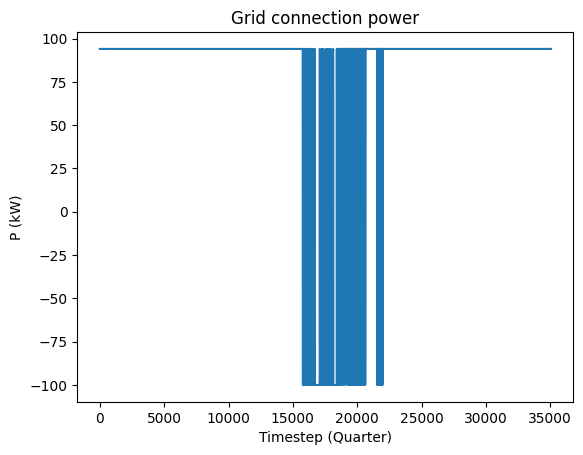

In [616]:
# Grid power

data = [P_grid[t].X for t in range(ts)]
title = "Grid connection power"
name = "P_grid"
yaxis = "P (kW)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)

Pg = [P_grid[t].X for t in range(ts)]

plt.figure(12)
plt.plot(Pg)
plt.title("Grid connection power")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("P (kW)")
plt.show()



Battery

In [617]:
# Battery power and energy

Pbat = [P_bess[t].X for t in range(ts)]

Ebat = [E_bess[t].X for t in range(ts)]



data = Pbat
title = "Battery power (negative is charged)"
name = "P_bat"
yaxis = "P (MW)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)


data = Ebat
title = "Battery energy (SOC)"
name = "E_bat"
yaxis = "E (MWh)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)



PVT

In [618]:
# Qdot PVT

Qdotpvt = [Qdot_pvt[t].X for t in range(ts)]


# plt.figure(12)
# plt.plot(Qdotpvt)
# plt.title("Heat power single PVT panel")
# plt.xlabel("Timestep (Quarter)")
# plt.ylabel("P (W)")
# plt.show()

QdotpvtT = [nPVT * Qdot_pvt[t].X / 1000 for t in range(ts)]


# plt.figure(12)
# plt.plot(QdotpvtT)
# plt.title("Heat power PVT system")
# plt.xlabel("Timestep (Quarter)")
# plt.ylabel("P (kW)")
# plt.show()


data = QdotpvtT
title = "Heating power PVT system"
name = "Qdot_pvt"
yaxis = "P (kW)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)

In [619]:
# P pvt

Ppvt = [P_pvt[t].X for t in range(ts)]

data = Ppvt
title = "Electrical power PVT system"
name = "P_pvt"
yaxis = "P (kW)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)


# plt.figure(12)
# plt.plot(Ppvt)
# plt.title("Electrical power PVT panels")
# plt.xlabel("Timestep (Quarter)")
# plt.ylabel("P (kW)")
# plt.show()

PV

In [620]:
# P pv

Ppv = [P_pv[t].X for t in range(ts)]


data = Ppv
title = "Electrical power PV panels"
name = "P_pv"
yaxis = "P (kW)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)

# plt.figure(12)
# plt.plot(Ppv)
# plt.title("Electrical power PV panels")
# plt.xlabel("Timestep (Quarter)")
# plt.ylabel("P (kW)")
# plt.show()

In [621]:
# P demand

Pdemand = [P_demand[t] for t in range(ts)]

data = Pdemand
title = "Electrical power demand Werf"
name = "P_demand"
yaxis = "P (kW)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)


# plt.figure(12)
# plt.plot(P_demand)
# plt.title("Electrical power demand Werf")
# plt.xlabel("Timestep (Quarter)")
# plt.ylabel("P (kW)")
# plt.show()

In [622]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]



month = 2920

jan = P_demand[month*0:month*1]
feb = P_demand[month*1:month*2]
mar = P_demand[month*2:month*3]
apr = P_demand[month*3:month*4]
may = P_demand[month*4:month*5]
jun = P_demand[month*5:month*6]
jul = P_demand[month*6:month*7]
aug = P_demand[month*7:month*8]
sep = P_demand[month*8:month*9]
okt = P_demand[month*9:month*10]
nov = P_demand[month*10:month*11]
dec = P_demand[month*11:month*12]

data = {
    "Jan": jan,
    "Feb": feb,
    "Mar": mar,
    "Apr": apr,
    "May": may,
    "Jun": jun,
    "Jul": jul,
    "Aug": aug,
    "Sep": sep,
    "Oct": okt,
    "Nov": nov,
    "Dec": dec,
}

# Create the DataFrame
P_demand_frame = pd.DataFrame(data)


sumP_demand_Frame = pd.DataFrame(P_demand_frame.sum()).transpose()
monthly_sums_demand = P_demand_frame.sum()

print(monthly_sums_demand["Jan"])

458817.13289256254


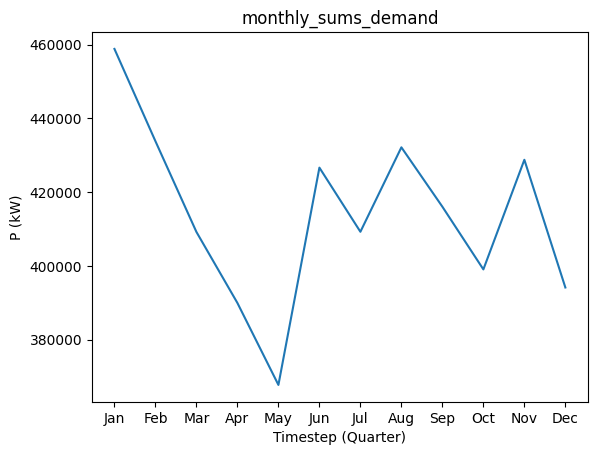

In [623]:
plt.figure(12)
plt.plot(monthly_sums_demand)
plt.title("monthly_sums_demand")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("P (kW)")
plt.show()

In [624]:
# P pv

Phpx = [P_hp_x[t].X for t in range(ts)]

data = Phpx
title = "Extra air to water HP"
name = "P_hpx"
yaxis = "P (kW)"

path = f"{saveDir}{name}/"

os.makedirs(path, exist_ok=True)

fig = plotGenerator.plotGen(title, data, name, None, None, ts, yaxis)

# fig.show()

if saveRun:

    np.savetxt(f"{path}/{name}.csv",data, delimiter=";")
    plotGenerator.save(name,data,fig,path)

# plt.figure(12)
# plt.plot(Phpx)
# plt.title("Curtail HP")
# plt.xlabel("Timestep (Quarter)")
# plt.ylabel("P (kW)")
# plt.show()